# NeSy4PPM: Single-attribute (activity) prediction Tutorial
This notebook demonstrates how to use the NeSy4PPM framework for single-attribute suffix prediction, specifically focused on activity prediction using neural architectures like LSTM and Transformer models. NeSy4PPM combines neural learning with symbolic background knowledge (BK) to produce accurate and compliant predictions under various conditions, including concept drift.

This notebook guides you through the full NeSy4PPM pipeline, including::

    1. Data preparation
    2. Learning pipeline
       A. Prefixes preprocessing
       B. Neural Network training
    3. Prediction pipeline

# 1. Data preparation
The first step in the NeSy4PPM pipeline is to load and transform the event log (in a `.xes`, `.csv` or `.xes.gz` format) into a symbolic representation using the `LogData` class, where activity labels are mapped to unique ASCII characters. Depending on the input configuration, the log can be:
- A __single event log__, which will be automatically split into training and test subsets based on the case start timestamps.
- A pair of __separate training and test logs__.

## Single event log:

In [4]:
from pathlib import Path
from NeSy4PPM.commons import log_utils
log_path = Path.cwd().parent/'data'/'input'/'logs'
log_name = "helpdesk.xes"
train_ratio = 0.8
case_name_key = 'case:concept:name'
act_name_key = 'concept:name'
timestamp_key = 'time:timestamp'

log_data = log_utils.LogData(log_path=log_path,log_name=log_name,train_ratio=train_ratio,
                             case_name_key=case_name_key,act_name_key=act_name_key,
                             timestamp_key=timestamp_key,resource=False)
print(f"Loaded log: {log_data.log_name}")
print(f"Trace max size: {log_data.max_len}")

parsing log, completed traces :: 100%|██████████| 4580/4580 [00:00<00:00, 5720.34it/s]


Loaded log: helpdesk
Trace max size: 15


## Separate training and test logs:

In [2]:
from pathlib import Path
from NeSy4PPM.commons import log_utils
log_path = Path.cwd().parent/'data'/'input'/'logs'
train_log = "helpdesk_train.xes"
test_log = "helpdesk_filtred.xes"

log_data = log_utils.LogData(log_path=log_path,train_log=train_log,test_log=test_log)
print(f"Loaded log: {log_data.log_name}")
print(f"Trace max size: {log_data.max_len}")

parsing log, completed traces :: 100%|██████████| 320/320 [00:00<00:00, 10233.91it/s]

Loaded log: helpdesk_train
Trace max size: 15


# 2. Learning pipeline
The __Learning Pipeline__ is responsible for transforming symbolic traces into neural-compatible inputs and training an LSTM or Transformer model to perform next activity prediction. This phase involves both __Prefixes preprocessing__ by extracting and encoding prefixes form training set, and __Neural network training__ that learn to generate the most likely continuations of incomplete process traces.

## A. Prefixes preprocessing
The `Prefixes preprocessing` step extracts prefixes (i.e., partial traces executions) from the training log and encodes them into numerical representations suitable for neural models. This can be done by calling `extract_trace_prefixes` and `encode_prefixes` for extracting and encoding prefixes, respectively or only by calling `extract_encode_prefixes` function.

### Step 1: Prefixes extraction
The `extract_trace_prefixes` function extracts all possible prefixes from each trace in the training log, up to a predefined maximum length. These prefixes represent partial executions of cases and are used as inputs to the neural model.

In [4]:
from NeSy4PPM.learning.prefixes_preprocessing import extract_trace_prefixes

extracted_prefixes = extract_trace_prefixes(log_data=log_data)

### Step 2: Prefixes encodings
To enable deep learning, extracted prefixes must be converted into vectorized formats. NeSy4PPM supports two encoding techniques for single attribute: (i) `One-hot` and (ii) `Index-based` encodings. Each encoding is implemented via the function `encode_prefixes` and prepares both input features (`x`) and target labels `y_a` for activity prediction.

#### a. One-hot encoding
In __One-hot encoding__, sequences of events are converted into high-dimensional binary feature vectors. Each feature corresponds to a one-hot encoded activity values derived from the log. This encoding can be applied by setting the `encoder` parameter to `Encodings.One_hot` in the `encode_prefixes` function:

In [5]:
from NeSy4PPM.learning.prefixes_preprocessing import encode_prefixes
from NeSy4PPM.commons.utils import Encodings

x, y_a, target_res= encode_prefixes(log_data,prefixes=extracted_prefixes,encoder=Encodings.One_hot)

Total chars: 13 - Target chars: 14
	 ['¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad']
Num. of training sequences: 16937
Vectorization...
Num. of features: 14


#### b. Index-based encoding
In __Index-based encoding__, sequences of events are transformed into numerical feature vectors. Each event is represented by an integer index that corresponds to the position of the activity in the predefined activity set. To apply index-based encoding, set the `encoder` parameter to `Encodings.Index_based` when calling the `encode_prefixes` function:


In [6]:
from NeSy4PPM.learning.prefixes_preprocessing import encode_prefixes
from NeSy4PPM.commons.utils import Encodings

x, y_a, _ = encode_prefixes(log_data,prefixes=extracted_prefixes, encoder=Encodings.Index_based)

Total chars: 13 - Target chars: 14
	 ['¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad']
Num. of training sequences: 16937
Vectorization...
Num. of features: 15


### Steps 1&2: End-to-End Prefixes preprocessing

In [9]:
from NeSy4PPM.learning.prefixes_preprocessing import extract_encode_prefixes
from NeSy4PPM.commons.utils import Encodings

encoder = Encodings.Index_based
x, y_a, _ = extract_encode_prefixes(log_data, encoder=encoder)

Total chars: 13 - Target chars: 14
	 ['¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad']
Num. of learning sequences: 16937
Vectorization...
Num. of features: 15


## B. Neural Network training
Once the prefixes are encoded, NeSy4PPM proceeds to train a neural network that learns to predict the next activity given a partial trace. The training is handled via the `train` function, which takes the encoded prefix data (`x`, `y_a`) and builds a model according to the chosen architecture. NeSy4PPM supports two neural architectures:

- __LSTM (Long Short-Term Memory)__ networks, which are recurrent neural networks designed to handle sequential data with long-range dependencies. To use LSTM, set the `model_arch` parameter to `NN_model.LSTM`.
- __Transformer__ architectures, which use attention mechanisms to model relationships across all positions in the prefix sequence simultaneously. To use a Transformer, set the `model_arch` parameter to `NN_model.Transformer`.

Build model...


C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


Checkpoint path: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\0\models\CF\helpdesk_train
Checkpoint name pattern: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\0\models\CF\helpdesk_train\model_{epoch:03d}-{val_loss:.3f}.keras
Epoch 1/100


C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randra

847/847 - 4s - loss: 0.7954 - val_loss: 0.4763 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 2/100
847/847 - 3s - loss: 0.4853 - val_loss: 0.4558 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 3/100
847/847 - 3s - loss: 0.4682 - val_loss: 0.4541 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 4/100
847/847 - 3s - loss: 0.4621 - val_loss: 0.4362 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 5/100
847/847 - 4s - loss: 0.4603 - val_loss: 0.4352 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 6/100
847/847 - 4s - loss: 0.4577 - val_loss: 0.4339 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 7/100
847/847 - 3s - loss: 0.4555 - val_loss: 0.4328 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 8/100
847/847 - 4s - loss: 0.4520 - val_loss: 0.4353 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 9/100
847/847 - 3s - loss: 0.4522 - val_loss: 0.4308 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 10/100
847/847 - 3s - loss: 0.4527 - val_loss: 0.4297 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 11/100
847/847 - 4s - loss: 0.4492 - val_loss: 0.4370 - lr: 0.001

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\JOukharijane\\Desktop\\PostDoc\\NeSy4PPM\\venv\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\JOukharijane\\Desktop\\PostDoc\\NeSy4PPM\\venv\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Us

Build model...
Checkpoint path: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\1\models\CF\helpdesk_train
Checkpoint name pattern: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\1\models\CF\helpdesk_train\model_{epoch:03d}-{val_loss:.3f}.keras


C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randra

Epoch 1/100
847/847 - 5s - loss: 0.8693 - val_loss: 0.4889 - lr: 0.0010 - 5s/epoch - 6ms/step
Epoch 2/100
847/847 - 4s - loss: 0.4981 - val_loss: 0.4528 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 3/100
847/847 - 4s - loss: 0.4719 - val_loss: 0.4489 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 4/100
847/847 - 4s - loss: 0.4625 - val_loss: 0.4449 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 5/100
847/847 - 4s - loss: 0.4593 - val_loss: 0.4357 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 6/100
847/847 - 4s - loss: 0.4544 - val_loss: 0.4312 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 7/100
847/847 - 5s - loss: 0.4542 - val_loss: 0.4363 - lr: 0.0010 - 5s/epoch - 6ms/step
Epoch 8/100
847/847 - 4s - loss: 0.4510 - val_loss: 0.4354 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 9/100
847/847 - 5s - loss: 0.4517 - val_loss: 0.4311 - lr: 0.0010 - 5s/epoch - 6ms/step
Epoch 10/100
847/847 - 5s - loss: 0.4496 - val_loss: 0.4282 - lr: 0.0010 - 5s/epoch - 6ms/step
Epoch 11/100
847/847 - 5s - loss: 0.4488 - val_loss: 0.4311

C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randra

Checkpoint path: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\2\models\CF\helpdesk_train
Checkpoint name pattern: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\2\models\CF\helpdesk_train\model_{epoch:03d}-{val_loss:.3f}.keras
Epoch 1/100


C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


847/847 - 5s - loss: 0.8540 - val_loss: 0.4699 - lr: 0.0010 - 5s/epoch - 6ms/step
Epoch 2/100
847/847 - 4s - loss: 0.4835 - val_loss: 0.4599 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 3/100
847/847 - 4s - loss: 0.4676 - val_loss: 0.4660 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 4/100
847/847 - 4s - loss: 0.4620 - val_loss: 0.4431 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 5/100
847/847 - 4s - loss: 0.4572 - val_loss: 0.4394 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 6/100
847/847 - 4s - loss: 0.4546 - val_loss: 0.4348 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 7/100
847/847 - 4s - loss: 0.4546 - val_loss: 0.4299 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 8/100
847/847 - 4s - loss: 0.4520 - val_loss: 0.4284 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 9/100
847/847 - 4s - loss: 0.4526 - val_loss: 0.4323 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 10/100
847/847 - 4s - loss: 0.4493 - val_loss: 0.4257 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 11/100
847/847 - 4s - loss: 0.4480 - val_loss: 0.4271 - lr: 0.001

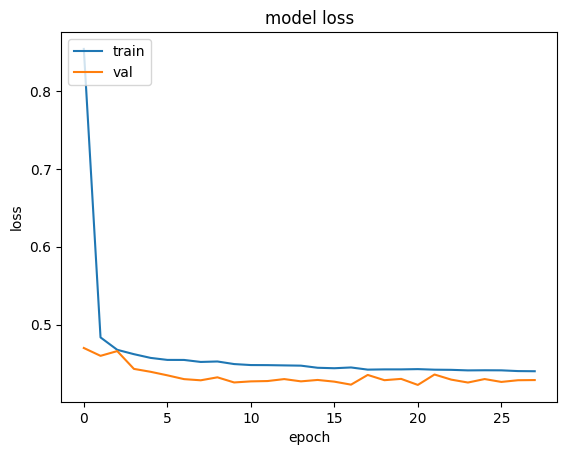

In [6]:
from NeSy4PPM.learning.train_model import train
from NeSy4PPM.commons.utils import NN_model

model = NN_model.Transformer
model_folder= Path.cwd().parent/'data'/'output'
train(log_data, encoder, model_arch=model, output_folder=model_folder, x=x, y_a=y_a)

# 3. Prediction Pipeline

The __Prediction Pipeline__ in NeSy4PPM is responsible for generating activity suffix predictions from a prefix (i.e., an incomplete trace) using a trained neural model. To enhance both accuracy and compliance under concept drift, it supports two main prediction modes:
- __BK-contextualized Beam Search__: the BK is used *during* beam search to guide which branches are explored based on compliance.
- __BK-based Filtering__: the BK is used *after* the beam search to filter out non-compliant predicted suffixes.

## Step 1: Set prediction parameters
The prediction process begins by specifying the following parameters that control how the prediction algorithm operates:
- `log_data.evaluation_prefix_start`: the minimum prefix length (in events) for prediction.
- `log_data.evaluation_prefix_end`: the maximum prefix length for prediction.
- `model`: the trained model architecture (`NN_model.LSTM` or `NN_model.Transformer`).
- `encoder`: the encoding method used during training (`Encodings.One_hot` or `Encodings.Index_based`).
- `output_folder`: the path where the trained model and prediction results are saved.
- `bk_file_path`: the path where the `BK` file exists.
- `beam_size`: the number of alternative suffixes explored in parallel by the beam search.
- `weight`: a float value in [0, 1] that balances the importance of neural predictions and BK compliance. A lower value emphasizes the neural model; a higher value gives more importance to BK.
- `BK_end`: a boolean parameter indicating whether BK is applied at the end (i.e., filtering) instead of during the search,
- `fitness_method`: the method used to compute compliance scores—i.e., the alignment or replay fitness between the predicted trace and the procedural model. This parameter is only applicable when the BK model is procedural, and must be set to one of the following: : `conformance_diagnostics_alignments`, `fitness_alignments`, `conformance_diagnostics_token_based_replay` or `fitness_token_based_replay`.


In [6]:
from NeSy4PPM.commons.utils import NN_model
from NeSy4PPM.commons.utils import Encodings

(log_data.evaluation_prefix_start, log_data.evaluation_prefix_end) = (1,4)
model = NN_model.Transformer
encoder = Encodings.Index_based
output_folder= Path.cwd().parent/'data'/'output'
bk_file_path = Path.cwd().parent/'data'/'input'/'declare_models'/'BK_helpdesk_filtred.decl'
beam_size = 3
weight = [0.9]
BK_end = False

## Step 2: Load the Background Knowledge (BK)
After setting the parameters, a background knowledge (BK) model must be loaded using the `load_bk` function. `BK` can represent domain constraints or business rules, and can be encoded in various formats:

- __Procedural models__: `.bpmn` (Business Process Model and Notation), `.pnml` (Petri Nets)
- __Declare models__: `.decl` (Declare constraints)
- __Probabilistic Declare models__: `.txt` (Declare constraints annotated with probabilities)

In [7]:
from NeSy4PPM.commons.utils import load_bk

bk_model = load_bk(bk_file_path)

0 Alternate Precedence[Wait, Closed] | | |
1 Alternate Response[Assign seriousness, Wait] | | |
2 Alternate Precedence[Wait, Resolve ticket] | | |
3 Exactly1[Wait] | |
4 Chain Response[Take in charge ticket, Wait] | | |


## Step 3: Perform Prediction
NeSy4PPM implements the `predict_evaluate` function, which generates activity suffixes using the proposed neuro-symbolic beam search algorithm and computes two evaluation metrics:
   - __Damerau-Levenshtein Similarity__, measuring the similarity between the predicted and actual suffixes based on edit distance,
   - __Jaccard Similarity__, measuring the overlap between the sets of predicted and actual activities. suffix prediction using a trained neural model and loaded `BK` model.

By default, this function operates on the __entire test log__, predicting suffixes for all traces defined in the test set. However, it can also be used to predict suffixes for a specific __subset of traces__ by providing a list of case IDs from the test log.

In [ ]:
### Entire test log prediction
from NeSy4PPM.prediction import evaluation

evaluation.predict_evaluate(log_data, model=model, encoder=encoder,
                            output_folder=output_folder, bk_model=bk_model, beam_size=beam_size, weight=weight)


In [8]:
### A subset of test log prediction
from NeSy4PPM.prediction import evaluation
traces_ids = ['Case 1327']
evaluation.predict_evaluate(log_data, model=model, encoder=encoder,evaluation_trace_ids= traces_ids,
                            output_folder=output_folder, bk_model=bk_model, beam_size=beam_size, weight=weight)

DEBUG:h5py._conv:Creating converter from 3 to 5


fold 0 - Activity Prediction
Model filepath: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\0\models\CF\helpdesk_train
Latest checkpoint file: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\0\models\CF\helpdesk_train\model_020-0.424.keras


C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randra

Beam size: 3, act_prefix: ¡ 
Iteration: 0
Temp prediction: ¢, Temp res prediction: None, Probability:-0.7133723825216294
Iteration: 1
Temp prediction: ¥, Temp res prediction: None, Probability:-0.8365750581026077
Iteration: 2
Temp prediction: ¦, Temp res prediction: None, Probability:-1.5603374958038327
Beam size: 3, act_prefix: ¡¢ 
Iteration: 0
Temp prediction: ¥, Temp res prediction: None, Probability:-1.2309218287467956
Iteration: 1
Temp prediction: !, Temp res prediction: None, Probability:-inf
Iteration: 2
Temp prediction: ­, Temp res prediction: None, Probability:-inf
Beam size: 3, act_prefix: ¡¥ 
Iteration: 0
Temp prediction: £, Temp res prediction: None, Probability:-1.3418305456638335
Iteration: 1
Temp prediction: ¢, Temp res prediction: None, Probability:-1.3420710861682892
Iteration: 2
Temp prediction: ¡, Temp res prediction: None, Probability:-1.897278669476509
Beam size: 3, act_prefix: ¡¦ 
Iteration: 0
Temp prediction: ¥, Temp res prediction: None, Probability:-2.170741322

C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

Beam size: 3, act_prefix: ¡¥ 
Iteration: 0
Temp prediction: £, Temp res prediction: None, Probability:-0.5052554875612258
Iteration: 1
Temp prediction: ¢, Temp res prediction: None, Probability:-0.5054960280656815
Iteration: 2
Temp prediction: ¡, Temp res prediction: None, Probability:-1.0607036113739012
Beam size: 3, act_prefix: ¡¥£ 
Iteration: 0
Temp prediction: ¤, Temp res prediction: None, Probability:-0.8876301884651183
Iteration: 1
Temp prediction: !, Temp res prediction: None, Probability:-1.3572218686342237
Iteration: 2
Temp prediction: ¢, Temp res prediction: None, Probability:-1.3672367841005324
Beam size: 3, act_prefix: ¡¥¢ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-inf
Iteration: 1
Temp prediction: ­, Temp res prediction: None, Probability:-inf
Iteration: 2
Temp prediction: ¬, Temp res prediction: None, Probability:-inf
Beam size: 3, act_prefix: ¡¥¡ 
Iteration: 0


C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Temp prediction: £, Temp res prediction: None, Probability:-1.6286725759506224
Iteration: 1
Temp prediction: ¢, Temp res prediction: None, Probability:-1.6892523050308226
Iteration: 2
Temp prediction: ¤, Temp res prediction: None, Probability:-2.2699880599975586
Beam size: 3, act_prefix: ¡¥£¤ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-0.8878840088611468
Iteration: 1
Temp prediction: «, Temp res prediction: None, Probability:-2.240807810425758
Iteration: 2
Temp prediction: ¢, Temp res prediction: None, Probability:-2.318035900592804
Beam size: 3, act_prefix: ¡¥£¢ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-inf
Iteration: 1
Temp prediction: ­, Temp res prediction: None, Probability:-inf
Iteration: 2
Temp prediction: ¬, Temp res prediction: None, Probability:-inf
['Case 1327', 2, 'Assign seriousness, Wait', 'Resolve ticket, Closed', 'Resolve ticket, Closed', 1.0, 1.0, 0.9, '£¤']


  0%|          | 0/1 [00:00<?, ?it/s]

Beam size: 3, act_prefix: ¡¥£ 


C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Iteration: 0
Temp prediction: ¤, Temp res prediction: None, Probability:-0.38237470090389253
Iteration: 1
Temp prediction: !, Temp res prediction: None, Probability:-0.8519663810729978
Iteration: 2
Temp prediction: ¢, Temp res prediction: None, Probability:-0.8619812965393066
Beam size: 3, act_prefix: ¡¥£¤ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-0.382628521299921
Iteration: 1
Temp prediction: «, Temp res prediction: None, Probability:-1.7355523228645322
Iteration: 2
Temp prediction: ¢, Temp res prediction: None, Probability:-1.8127804130315779
Beam size: 3, act_prefix: ¡¥£¢ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-inf
Iteration: 1
Temp prediction: ­, Temp res prediction: None, Probability:-inf
Iteration: 2
Temp prediction: ¬, Temp res prediction: None, Probability:-inf
['Case 1327', 3, 'Assign seriousness, Wait, Resolve ticket', 'Closed', 'Closed', 1.0, 1.0, 0.9, '¤']


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:00<00:00, 66.62it/s]

TIME TO FINISH --- 2.284745216369629 seconds ---
fold 1 - Activity Prediction
Model filepath: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\1\models\CF\helpdesk_train
Latest checkpoint file: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\1\models\CF\helpdesk_train\model_022-0.424.keras



C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randr

Beam size: 3, act_prefix: ¡ 
Iteration: 0
Temp prediction: ¢, Temp res prediction: None, Probability:-0.7111556112766266
Iteration: 1
Temp prediction: ¥, Temp res prediction: None, Probability:-0.8162247449159621
Iteration: 2
Temp prediction: ¦, Temp res prediction: None, Probability:-1.5323061466217038
Beam size: 3, act_prefix: ¡¢ 
Iteration: 0
Temp prediction: ¥, Temp res prediction: None, Probability:-1.2274900048971176
Iteration: 1
Temp prediction: !, Temp res prediction: None, Probability:-inf
Iteration: 2
Temp prediction: ­, Temp res prediction: None, Probability:-inf
Beam size: 3, act_prefix: ¡¥ 
Iteration: 0
Temp prediction: £, Temp res prediction: None, Probability:-1.302116149663925
Iteration: 1
Temp prediction: ¢, Temp res prediction: None, Probability:-1.3351145178079604
Iteration: 2
Temp prediction: ¡, Temp res prediction: None, Probability:-1.8043173581361769
Beam size: 3, act_prefix: ¡¦ 
Iteration: 0
Temp prediction: ¥, Temp res prediction: None, Probability:-2.125188425

C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Beam size: 3, act_prefix: ¡¥£¤ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-1.6873603036627172
Iteration: 1
Temp prediction: «, Temp res prediction: None, Probability:-2.9994284793734547
Iteration: 2
Temp prediction: ª, Temp res prediction: None, Probability:-3.219291417300701
Beam size: 3, act_prefix: ¡¢¥¢ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-inf
Iteration: 1
Temp prediction: ­, Temp res prediction: None, Probability:-inf
Iteration: 2
Temp prediction: ¬, Temp res prediction: None, Probability:-inf
['Case 1327', 1, 'Assign seriousness', 'Wait, Resolve ticket, Closed', 'Wait, Resolve ticket, Closed', 1.0, 1.0, 0.9, '¥£¤']


  0%|          | 0/1 [00:00<?, ?it/s]

Beam size: 3, act_prefix: ¡¥ 
Iteration: 0
Temp prediction: £, Temp res prediction: None, Probability:-0.48589140474796294
Iteration: 1
Temp prediction: ¢, Temp res prediction: None, Probability:-0.5188897728919983
Iteration: 2
Temp prediction: ¡, Temp res prediction: None, Probability:-0.9880926132202148
Beam size: 3, act_prefix: ¡¥£ 
Iteration: 0
Temp prediction: ¤, Temp res prediction: None, Probability:-0.8709128007292748
Iteration: 1
Temp prediction: !, Temp res prediction: None, Probability:-1.2295097023248671
Iteration: 2
Temp prediction: ¢, Temp res prediction: None, Probability:-1.2990904241800307
Beam size: 3, act_prefix: ¡¥¢ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-inf
Iteration: 1
Temp prediction: ­, Temp res prediction: None, Probability:-inf
Iteration: 2
Temp prediction: ¬, Temp res prediction: None, Probability:-inf
Beam size: 3, act_prefix: ¡¥¡ 
Iteration: 0
Temp prediction: £, Temp res prediction: None, Probability:-1.5696405172348022
I

C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-0.8711355587467552
Iteration: 1
Temp prediction: «, Temp res prediction: None, Probability:-2.183203734457493
Iteration: 2
Temp prediction: ª, Temp res prediction: None, Probability:-2.403066672384739
Beam size: 3, act_prefix: ¡¥£¢ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-inf
Iteration: 1
Temp prediction: ­, Temp res prediction: None, Probability:-inf
Iteration: 2
Temp prediction: ¬, Temp res prediction: None, Probability:-inf
['Case 1327', 2, 'Assign seriousness, Wait', 'Resolve ticket, Closed', 'Resolve ticket, Closed', 1.0, 1.0, 0.9, '£¤']


  0%|          | 0/1 [00:00<?, ?it/s]

Beam size: 3, act_prefix: ¡¥£ 
Iteration: 0
Temp prediction: ¤, Temp res prediction: None, Probability:-0.3850213959813118
Iteration: 1
Temp prediction: !, Temp res prediction: None, Probability:-0.7436182975769041
Iteration: 2
Temp prediction: ¢, Temp res prediction: None, Probability:-0.8131990194320677
Beam size: 3, act_prefix: ¡¥£¤ 


C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-0.3852441539987922
Iteration: 1
Temp prediction: «, Temp res prediction: None, Probability:-1.6973123297095296
Iteration: 2
Temp prediction: ª, Temp res prediction: None, Probability:-1.9171752676367757
Beam size: 3, act_prefix: ¡¥£¢ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-inf
Iteration: 1
Temp prediction: ­, Temp res prediction: None, Probability:-inf
Iteration: 2
Temp prediction: ¬, Temp res prediction: None, Probability:-inf
['Case 1327', 3, 'Assign seriousness, Wait, Resolve ticket', 'Closed', 'Closed', 1.0, 1.0, 0.9, '¤']


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:00<?, ?it/s]

TIME TO FINISH --- 3.872352123260498 seconds ---
fold 2 - Activity Prediction
Model filepath: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\2\models\CF\helpdesk_train
Latest checkpoint file: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\2\models\CF\helpdesk_train\model_021-0.423.keras



C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randr

Beam size: 3, act_prefix: ¡ 
Iteration: 0
Temp prediction: ¢, Temp res prediction: None, Probability:-0.7118123337626457
Iteration: 1
Temp prediction: ¥, Temp res prediction: None, Probability:-0.8088245660066604
Iteration: 2
Temp prediction: ¦, Temp res prediction: None, Probability:-1.4841304302215574
Beam size: 3, act_prefix: ¡¢ 
Iteration: 0
Temp prediction: ¥, Temp res prediction: None, Probability:-1.2448329761624337
Iteration: 1
Temp prediction: !, Temp res prediction: None, Probability:-inf
Iteration: 2
Temp prediction: ­, Temp res prediction: None, Probability:-inf
Beam size: 3, act_prefix: ¡¥ 
Iteration: 0
Temp prediction: £, Temp res prediction: None, Probability:-1.3031928360462188
Iteration: 1
Temp prediction: ¢, Temp res prediction: None, Probability:-1.3235062688589094
Iteration: 2
Temp prediction: ¡, Temp res prediction: None, Probability:-1.7554365426301954
Beam size: 3, act_prefix: ¡¦ 
Iteration: 0
Temp prediction: ¥, Temp res prediction: None, Probability:-2.07132137

C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Beam size: 3, act_prefix: ¡¢¥£ 
Iteration: 0
Temp prediction: ¤, Temp res prediction: None, Probability:-2.067771388962865
Iteration: 1
Temp prediction: !, Temp res prediction: None, Probability:-2.4318175598978993
Iteration: 2
Temp prediction: ¢, Temp res prediction: None, Probability:-2.5466035172343253
Beam size: 3, act_prefix: ¡¢¥¢ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-inf
Iteration: 1
Temp prediction: ­, Temp res prediction: None, Probability:-inf
Iteration: 2
Temp prediction: ¬, Temp res prediction: None, Probability:-inf
['Case 1327', 1, 'Assign seriousness', 'Wait, Resolve ticket, Closed', 'Wait, Resolve ticket, Closed', 1.0, 1.0, 0.9, '¥£¤']


  0%|          | 0/1 [00:00<?, ?it/s]

Beam size: 3, act_prefix: ¡¥ 
Iteration: 0
Temp prediction: £, Temp res prediction: None, Probability:-0.4943682700395584
Iteration: 1
Temp prediction: ¢, Temp res prediction: None, Probability:-0.5146817028522491
Iteration: 2
Temp prediction: ¡, Temp res prediction: None, Probability:-0.946611976623535
Beam size: 3, act_prefix: ¡¥£ 
Iteration: 0
Temp prediction: ¤, Temp res prediction: None, Probability:-0.8754834100604058
Iteration: 1
Temp prediction: !, Temp res prediction: None, Probability:-1.2279023200273511
Iteration: 2
Temp prediction: ¢, Temp res prediction: None, Probability:-1.3364901095628738
Beam size: 3, act_prefix: ¡¥¢ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-inf
Iteration: 1
Temp prediction: ­, Temp res prediction: None, Probability:-inf
Iteration: 2
Temp prediction: ¬, Temp res prediction: None, Probability:-inf
Beam size: 3, act_prefix: ¡¥¡ 
Iteration: 0
Temp prediction: £, Temp res prediction: None, Probability:-1.5410490036010742
Ite

C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

Beam size: 3, act_prefix: ¡¥£¤ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-0.8756451528402976
Iteration: 1
Temp prediction: «, Temp res prediction: None, Probability:-2.289967603981495
Iteration: 2
Temp prediction: ª, Temp res prediction: None, Probability:-2.4015624716877935
Beam size: 3, act_prefix: ¡¥£¢ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-inf
Iteration: 1
Temp prediction: ­, Temp res prediction: None, Probability:-inf
Iteration: 2
Temp prediction: ¬, Temp res prediction: None, Probability:-inf
['Case 1327', 2, 'Assign seriousness, Wait', 'Resolve ticket, Closed', 'Resolve ticket, Closed', 1.0, 1.0, 0.9, '£¤']



  0%|          | 0/1 [00:00<?, ?it/s]

Beam size: 3, act_prefix: ¡¥£ 
Iteration: 0
Temp prediction: ¤, Temp res prediction: None, Probability:-0.38111514002084734
Iteration: 1
Temp prediction: !, Temp res prediction: None, Probability:-0.7335340499877928
Iteration: 2
Temp prediction: ¢, Temp res prediction: None, Probability:-0.8421218395233154
Beam size: 3, act_prefix: ¡¥£¤ 


C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-0.3812768828007393
Iteration: 1
Temp prediction: «, Temp res prediction: None, Probability:-1.7955993339419365
Iteration: 2
Temp prediction: ª, Temp res prediction: None, Probability:-1.907194201648235
Beam size: 3, act_prefix: ¡¥£¢ 
Iteration: 0
Temp prediction: !, Temp res prediction: None, Probability:-inf
Iteration: 1
Temp prediction: ­, Temp res prediction: None, Probability:-inf
Iteration: 2
Temp prediction: ¬, Temp res prediction: None, Probability:-inf
['Case 1327', 3, 'Assign seriousness, Wait, Resolve ticket', 'Closed', 'Closed', 1.0, 1.0, 0.9, '¤']


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:00<?, ?it/s]

TIME TO FINISH --- 5.3550262451171875 seconds ---


## Steps 2&3: End-to-End Prediction

